# Case Study 2 - Results

In [ ]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet
import scipy.optimize as sco
from pathlib import Path
import pickle
import dill
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import functions as fct

file_path = "/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Thesis"
save_path = "/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25"

colorblind_colors = colors = plt.get_cmap('tab10').colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [908]:
def maximize_return_given_risk(target_volatility, mean_returns, cov_matrix, initial_guess):
    num_assets = len(mean_returns)

    def portfolio_return(weights):
        return -np.dot(weights, mean_returns)

    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: target_volatility - portfolio_volatility(w)}  # relaxed
    )

    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(portfolio_return, initial_guess,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints,
                      options={'maxiter': 6000, 'ftol': 1e-9})

    if result.success:
        return result.x, -result.fun
    else:
        raise ValueError("Optimization failed: " + result.message)


## Define Countries and Variables for Cat Bond Development

In [155]:
#list countries for case study 2
countries = [480, 212, 882, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585] 

# resultion and coordinate system requirements per country
countries_150 = [332, 388, 214, 44, 548, 192, 84, 90] 
fiji = [242]
countries_30 = [480, 212, 670, 28, 52, 662, 659, 308, 882, 780, 570, 776, 174, 184, 584, 585]

# iso 3 alpha codes
countries_str = ['MUS', 'DMA', 'WSM', 'HIT', 'VCT', 'ATG', 'JAM', 'BRB', 'LCA', 'KNA', 'GRD', 'DOM', 'BHS', 'VUT', 'FJI', 'TTO', 'CUB', 'NIU', 'BLZ', 'TON', 'SLB', 'COM', 'COK', 'MHL', 'PLW']
ed250 = [50.9, 37.8, 36.4, 35.5, 35.4, 35.3, 35.1, 34.8, 34.0, 34.0, 33.7, 31.5, 29.6, 28.2, 25.7, 25.5, 24.6, 24.3, 22.0, 17.7, 14.4, 12.7, 11.7, 7.4, 6.1]
#assign risk pools to each sceanrio/portfolio
scenario_1 = [[480, 212, 882, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]] 
scenario_2 = [[480, 332, 28, 388, 52, 662, 659, 214, 44, 242, 780, 192, 184, 584], [212, 882, 670, 308, 548, 570, 84, 776, 90, 174, 585]]
scenario_3 = [[212, 882, 670, 308, 548, 570, 84, 776, 90, 174, 184], [584, 585], [480, 332, 28, 388, 52, 662, 659, 214, 44, 242, 780, 192]]
scenario_4 = [[212, 882, 670, 308, 548, 84, 776, 90, 174], [480, 332, 388, 214, 192], [584, 585], [28, 52, 662, 659, 44, 242, 780, 570, 184]]
scenario_5 = [[776, 90, 174, 184], [212, 882, 670, 308, 548, 84], [584, 585], [480, 332, 52, 662, 659, 44, 242, 780, 570], [28, 388, 214, 192]]

#set risk free rate
rf_rates = 0.00

#set benchmark sharpe ratio 
target_sharpe = 0.5

#define bond setting
lower_share = 0.05
prot_rp = 250


## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

In [8]:
#import single country bonds results
sng_ann_ret_df_ibrd = pd.read_csv(Path(file_path, "simulation_results/sng_returns_ibrd.csv"))
sng_ann_ret_df_regression = pd.read_csv(Path(file_path, "simulation_results/sng_returns_regression.csv"))
sng_ann_ret_df_required = pd.read_csv(Path(file_path, "simulation_results/sng_returns_required.csv"))
sng_es_metrics = pd.read_csv(Path(file_path, "simulation_results/sng_es.csv"))
output_path = Path(file_path, "simulation_results/bond_metrics_sng_dic.pkl")
with open(output_path, "rb") as file:
    bond_metrics_sng_dic = pickle.load(file)

sng_ann_ret_required = sng_ann_ret_df_required.to_dict('series')
sng_ann_ret_regression = sng_ann_ret_df_regression.to_dict('series')
sng_ann_ret_ibrd = sng_ann_ret_df_ibrd.to_dict('series')
sng_es_metrics = sng_es_metrics.to_dict('series')

nominal_sng_dic_df = pd.read_csv(Path(file_path, "simulation_results/nominal_dic_df.csv"))
# Specify the output path
output_path = Path(file_path, "simulation_results/pay_dam_df_dic.pkl")
with open(output_path, "rb") as file:
    pay_dam_df_sng_dic = pickle.load(file)

output_path = Path(file_path, "simulation_results/premium_dic_sng_dic.pkl")
with open(output_path, "rb") as file:
    premium_dic_sng_dic = pickle.load(file)

nominal_sng_dic = dict(zip(nominal_sng_dic_df["Key"], nominal_sng_dic_df["Value"]))

### Create Multi-Country bond

In [10]:
# simulate sceanrio 1 -5
# define tranches
tranches_array = np.array([50, 250, 1000])

ncf_s1 = {}
premiums_s1 = {}
premium_dic_s1 = {}
nominal_s1 = {}
es_metrics_s1 = {}
MES_cty_s1 = {}
tranches_s1 = {}

i = 0
for pool in scenario_1:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s1[str(i)], premiums_s1[str(i)], premium_dic_s1[str(i)], nominal_s1[str(i)], es_metrics_s1[str(i)], MES_cty_s1[str(i)], tranches_s1[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                                nominals_dic=nominal_dic_pool, tranches_array=tranches_array,
                                                                                                                                                                                peak_multi=0, opt_cap=True, 
                                                                                                                                                                                ibrd_path=Path(file_path))
        

ncf_s2 = {}
premiums_s2 = {}
premium_dic_s2 = {}
nominal_s2 = {}
es_metrics_s2 = {}
MES_cty_s2 = {}
tranches_s2 = {}

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s2[str(i)], premiums_s2[str(i)], premium_dic_s2[str(i)], nominal_s2[str(i)], es_metrics_s2[str(i)], MES_cty_s2[str(i)], tranches_s2[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path(file_path),
                                                                                                                                                                         peak_multi=0)
        

ncf_s3 = {}
premiums_s3 = {}
premium_dic_s3 = {}
nominal_s3 = {}
es_metrics_s3 = {}
MES_cty_s3 = {}
tranches_s3 = {}

i = 0
for pool in scenario_3:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s3[str(i)], premiums_s3[str(i)], premium_dic_s3[str(i)], nominal_s3[str(i)], es_metrics_s3[str(i)], MES_cty_s3[str(i)], tranches_s3[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path(file_path),
                                                                                                                                                                         peak_multi=0)
        

ncf_s4 = {}
premiums_s4 = {}
premium_dic_s4 = {}
nominal_s4 = {}
es_metrics_s4 = {}
MES_cty_s4 = {}
tranches_s4 = {}

i = 0
for pool in scenario_4:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s4[str(i)], premiums_s4[str(i)], premium_dic_s4[str(i)], nominal_s4[str(i)], es_metrics_s4[str(i)], MES_cty_s4[str(i)], tranches_s4[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path(file_path),
                                                                                                                                                                         peak_multi=0)
        

ncf_s5 = {}
premiums_s5 = {}
premium_dic_s5 = {}
nominal_s5 = {}
es_metrics_s5 = {}
MES_cty_s5 = {}
tranches_s5 = {}

i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5[str(i)], premiums_s5[str(i)], premium_dic_s5[str(i)], nominal_s5[str(i)], es_metrics_s5[str(i)], MES_cty_s5[str(i)], tranches_s5[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path(file_path),
                                                                                                                                                                         peak_multi=0) 

/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 37.25%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 35.5%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 59.33%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 59.55%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/simulate_multi_cty_bond.py:641: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 35.46%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 59.01%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 23.58%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/simulate_multi_cty_bond.py:641: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 35.82%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/simulate_multi_cty_bond.py:641: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


In [566]:
scenario_5

[[776, 90, 174, 184],
 [212, 882, 670, 308, 548, 84],
 [584, 585],
 [480, 332, 52, 662, 659, 44, 242, 780, 570],
 [28, 388, 214, 192]]

In [707]:
#adjust premiums for ibrd pricing and simulate
ncf_s5_a = {}
premiums_s5_a = {}
premium_dic_s5_a = {}
nominal_s5_a = {}
es_metrics_s5_a = {}
MES_cty_s5_a = {}
tranches_s5_a = {}

prem_corr_ibrd = [0.0045, 0.015, 0.005, 0.013, 0.005]
i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5_a[str(i)], premiums_s5_a[str(i)], premium_dic_s5_a[str(i)], nominal_s5_a[str(i)], es_metrics_s5_a[str(i)], MES_cty_s5_a[str(i)], tranches_s5_a[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, prem_corr=prem_corr_ibrd[i-1], ibrd_path=Path(file_path),
                                                                                                                                                                         peak_multi=0)
        
#adjust premiums for benchmark pricing and simulate
ncf_s5_a_b = {}
premiums_s5_a_b = {}
premium_dic_s5_a_b = {}
nominal_s5_a_b = {}
es_metrics_s5_a_b = {}
MES_cty_s5_a_b = {}
tranches_s5_a_b = {}

prem_corr_benchmark = [0.0045, 0.03, 0.015, 0.033, 0.007]
i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5_a_b[str(i)], premiums_s5_a_b[str(i)], premium_dic_s5_a_b[str(i)], nominal_s5_a_b[str(i)], es_metrics_s5_a_b[str(i)], MES_cty_s5_a_b[str(i)], tranches_s5_a_b[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                                                            nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                                                            opt_cap=True, prem_corr=prem_corr_benchmark[i-1], 
                                                                                                                                                                                                            ibrd_path=Path(file_path),
                                                                                                                                                                                                            peak_multi=0)

#adjust premiums for chatoro pricing and simulate
ncf_s5_a_r = {}
premiums_s5_a_r = {}
premium_dic_s5_a_r = {}
nominal_s5_a_r = {}
es_metrics_s5_a_r = {}
MES_cty_s5_a_r = {}
tranches_s5_a_r = {}

prem_corr_regression = [-0.006, 0.013, 0.045, 0.007, -0.015]
i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5_a_r[str(i)], premiums_s5_a_r[str(i)], premium_dic_s5_a_r[str(i)], nominal_s5_a_r[str(i)], es_metrics_s5_a_r[str(i)], MES_cty_s5_a_r[str(i)], tranches_s5_a_r[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                                                            nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                                                            opt_cap=True, prem_corr=prem_corr_regression[i-1], 
                                                                                                                                                                                                            ibrd_path=Path(file_path),
                                                                                                                                                                                                            peak_multi=0)

/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/simulate_multi_cty_bond.py:641: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/simulate_multi_cty_bond.py:641: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/simulate_multi_cty_bond.py:641: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25/Code/master_thesis_cat_bonds/functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


In [941]:
import os
import pickle

def save_scenario_dicts(scenario_key, scenario_dicts, file_path, scenario_name):
    """
    Save all scenario-related dictionaries for a given scenario_key as pickle files.
    Args:
        scenario_key: str, scenario identifier (e.g., 's1', 's3', etc.)
        scenario_dicts: dict, keys are dict names (e.g., 'ncf', 'premiums', etc.), values are the dicts to save.
        file_path: str or Path, base directory to save files.
        scenario_name: str, subdirectory for saving scenario files.
    """

    save_dir = Path(file_path, f"simulation_results/{scenario_name}/{scenario_key}")
    os.makedirs(save_dir, exist_ok=True)
    for dict_name, dic in scenario_dicts.items():
        with open(save_dir / f"{dict_name}.pkl", "wb") as f:
            pickle.dump(dic, f)

def load_scenario_dicts(scenario_key, dict_names, file_path, scenario_name):
    """
    Load all scenario-related dictionaries for a given scenario_key from pickle files.
    Args:
        scenario_key: str, scenario identifier (e.g., 's1', 's3', etc.)
        dict_names: list of str, names of dicts to load (e.g., ['ncf', 'premiums', ...])
        file_path: str or Path, base directory to load files from.
        scenario_name: str, subdirectory for loading scenario files.
    Returns:
        loaded_dicts: dict, keys are dict names, values are loaded dicts.
    """
    load_dir = Path(file_path, f"simulation_results/{scenario_name}/{scenario_key}")
    loaded_dicts = {}
    for dict_name in dict_names:
        with open(load_dir / f"{dict_name}.pkl", "rb") as f:
            loaded_dicts[dict_name] = pickle.load(f)
    return loaded_dicts


scenario_dicts_s1 = {
    'ncf': ncf_s1,
    'premiums': premiums_s1,
    'premium_dic': premium_dic_s1,
    'nominal': nominal_s1,
    'es_metrics': es_metrics_s1,
    'MES_cty': MES_cty_s1,
    'tranches': tranches_s1,
}

scenario_dicts_s3 = {
    'ncf': ncf_s3,
    'premiums': premiums_s3,
    'premium_dic': premium_dic_s3,
    'nominal': nominal_s3,
    'es_metrics': es_metrics_s3,
    'MES_cty': MES_cty_s3,
    'tranches': tranches_s3,
}

scenario_dicts_s5 = {
    'ncf': ncf_s5,
    'premiums': premiums_s5,
    'premium_dic': premium_dic_s5,
    'nominal': nominal_s5,
    'es_metrics': es_metrics_s5,
    'MES_cty': MES_cty_s5,
    'tranches': tranches_s5,
}

scenario_dicts_s5_a = {
    'ncf': ncf_s5_a,
    'premiums': premiums_s5_a,
    'premium_dic': premium_dic_s5_a,
    'nominal': nominal_s5_a,
    'es_metrics': es_metrics_s5_a,
    'MES_cty': MES_cty_s5_a,
    'tranches': tranches_s5_a,
}
scenario_dicts_s5_a_r = {
    'ncf': ncf_s5_a_r,
    'premiums': premiums_s5_a_r,
    'premium_dic': premium_dic_s5_a_r,
    'nominal': nominal_s5_a_r,
    'es_metrics': es_metrics_s5_a_r,
    'MES_cty': MES_cty_s5_a_r,
    'tranches': tranches_s5_a_r,
}

scenario_dicts_s5_a_b = {
    'ncf': ncf_s5_a_b,
    'premiums': premiums_s5_a_b,
    'premium_dic': premium_dic_s5_a_b,
    'nominal': nominal_s5_a_b,
    'es_metrics': es_metrics_s5_a_b,
    'MES_cty': MES_cty_s5_a_b,
    'tranches': tranches_s5_a_b,
}


save_scenario_dicts('s1', scenario_dicts_s1, file_path, "all_scenarios")
save_scenario_dicts('s3', scenario_dicts_s3, file_path, "all_scenarios")
save_scenario_dicts('s5', scenario_dicts_s5, file_path, "all_scenarios")
save_scenario_dicts('s5_a', scenario_dicts_s5_a, file_path, "all_scenarios")
save_scenario_dicts('s5_a_r', scenario_dicts_s5_a_r, file_path, "all_scenarios")
save_scenario_dicts('s5_a_b', scenario_dicts_s5_a_b, file_path, "all_scenarios")
loaded = load_scenario_dicts('s3', list(scenario_dicts_s3.keys()), file_path, "all_scenarios")


In [940]:
ncf_s3_loaded = loaded['ncf']
premiums_s3_loaded = loaded['premiums']
premium_dic_s3_loaded = loaded['premium_dic']
nominal_s3_loaded = loaded['nominal']
es_metrics_s3_loaded = loaded['es_metrics']
MES_cty_s3_loaded = loaded['MES_cty']
tranches_s3_loaded = loaded['tranches']

In [708]:
# extract for each scenario the simulated returns per pricing approach
s1_tranches_ann_ret_regr = {}
s1_tranches_ann_ret_ibrd ={}
s1_tranches_ann_ret_requ ={}

for key in ncf_s1["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s1:
            s1_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s1[pool]['regression'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s1[pool]['ibrd'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s1[pool]['required'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]

s2_tranches_ann_ret_regr = {}
s2_tranches_ann_ret_ibrd = {}
s2_tranches_ann_ret_requ = {}

for key in ncf_s2["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s2:
            s2_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s2[pool]['regression'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s2[pool]['ibrd'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s2[pool]['required'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]

s3_tranches_ann_ret_regr = {}
s3_tranches_ann_ret_ibrd = {}
s3_tranches_ann_ret_requ = {}

for key in ncf_s3["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s3:
            s3_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s3[pool]['regression'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s3[pool]['ibrd'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s3[pool]['required'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]


s4_tranches_ann_ret_regr = {}
s4_tranches_ann_ret_ibrd = {}
s4_tranches_ann_ret_requ = {}

for key in ncf_s4["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s4:
            s4_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s4[pool]['regression'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s4[pool]['ibrd'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s4[pool]['required'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]

s5_tranches_ann_ret_regr = {}
s5_tranches_ann_ret_ibrd = {}
s5_tranches_ann_ret_requ = {}

for key in ncf_s5["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5:
            s5_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5[pool]['regression'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5[pool]['ibrd'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5[pool]['required'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]


s5_a_tranches_ann_ret_regr = {}
s5_a_tranches_ann_ret_ibrd = {}
s5_a_tranches_ann_ret_requ = {}

for key in ncf_s5_a["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5_a:
            s5_a_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5_a[pool]['regression'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5_a[pool]['ibrd'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5_a[pool]['required'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]

s5_a_b_tranches_ann_ret_regr = {}
s5_a_b_tranches_ann_ret_ibrd = {}
s5_a_b_tranches_ann_ret_requ = {}

for key in ncf_s5_a_b["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5_a_b:
            s5_a_b_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5_a_b[pool]['regression'][key] / tranches_s5_a_b[pool].loc[tranches_s5_a_b[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_b_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5_a_b[pool]['ibrd'][key] / tranches_s5_a_b[pool].loc[tranches_s5_a_b[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_b_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5_a_b[pool]['required'][key] / tranches_s5_a_b[pool].loc[tranches_s5_a_b[pool]['RP'] == key, 'nominal'].iloc[0]

s5_a_r_tranches_ann_ret_regr = {}
s5_a_r_tranches_ann_ret_ibrd = {}
s5_a_r_tranches_ann_ret_requ = {}

for key in ncf_s5_a_r["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5_a_r:
            s5_a_r_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5_a_r[pool]['regression'][key] / tranches_s5_a_r[pool].loc[tranches_s5_a_r[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_r_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5_a_r[pool]['ibrd'][key] / tranches_s5_a_r[pool].loc[tranches_s5_a_r[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_r_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5_a_r[pool]['required'][key] / tranches_s5_a_r[pool].loc[tranches_s5_a_r[pool]['RP'] == key, 'nominal'].iloc[0]



s1_ann_ret_regr = {}
s1_ann_ret_ibrd = {}
s1_ann_ret_requ = {}
for pool in ncf_s1:
    s1_ann_ret_regr[pool] = 0
    s1_ann_ret_ibrd[pool] = 0
    s1_ann_ret_requ[pool] = 0
    for rp in ncf_s1[pool]['regression']:
        if rp != 'Total':
            s1_ann_ret_regr[pool] += ncf_s1[pool]['regression'][rp]
            s1_ann_ret_ibrd[pool] += ncf_s1[pool]['ibrd'][rp]
            s1_ann_ret_requ[pool] += ncf_s1[pool]['required'][rp]


s2_ann_ret_regr = {}
s2_ann_ret_ibrd = {}
s2_ann_ret_requ = {}
for pool in ncf_s2:
    s2_ann_ret_regr[pool] = 0
    s2_ann_ret_ibrd[pool] = 0
    s2_ann_ret_requ[pool] = 0
    for rp in ncf_s2[pool]['regression']:
        if rp != 'Total':
            s2_ann_ret_regr[pool] += ncf_s2[pool]['regression'][rp]
            s2_ann_ret_ibrd[pool] += ncf_s2[pool]['ibrd'][rp]
            s2_ann_ret_requ[pool] += ncf_s2[pool]['required'][rp]


s3_ann_ret_regr = {}
s3_ann_ret_ibrd = {}
s3_ann_ret_requ = {}
for pool in ncf_s3:
    s3_ann_ret_regr[pool] = 0
    s3_ann_ret_ibrd[pool] = 0
    s3_ann_ret_requ[pool] = 0
    for rp in ncf_s3[pool]['regression']:
        if rp != 'Total':
            s3_ann_ret_regr[pool] += ncf_s3[pool]['regression'][rp]
            s3_ann_ret_ibrd[pool] += ncf_s3[pool]['ibrd'][rp]
            s3_ann_ret_requ[pool] += ncf_s3[pool]['required'][rp]


s4_ann_ret_regr = {}
s4_ann_ret_ibrd = {}
s4_ann_ret_requ = {}
for pool in ncf_s4:
    s4_ann_ret_regr[pool] = 0
    s4_ann_ret_ibrd[pool] = 0
    s4_ann_ret_requ[pool] = 0
    for rp in ncf_s4[pool]['regression']:
        if rp != 'Total':
            s4_ann_ret_regr[pool] += ncf_s4[pool]['regression'][rp]
            s4_ann_ret_ibrd[pool] += ncf_s4[pool]['ibrd'][rp]
            s4_ann_ret_requ[pool] += ncf_s4[pool]['required'][rp]


s5_ann_ret_regr = {}
s5_ann_ret_ibrd = {}
s5_ann_ret_requ = {}
for pool in ncf_s5:
    s5_ann_ret_regr[pool] = 0
    s5_ann_ret_ibrd[pool] = 0
    s5_ann_ret_requ[pool] = 0
    for rp in ncf_s5[pool]['regression']:
        if rp != 'Total':
            s5_ann_ret_regr[pool] += ncf_s5[pool]['regression'][rp]
            s5_ann_ret_ibrd[pool] += ncf_s5[pool]['ibrd'][rp]
            s5_ann_ret_requ[pool] += ncf_s5[pool]['required'][rp]

s5_a_ann_ret_regr = {}
s5_a_ann_ret_ibrd = {}
s5_a_ann_ret_requ = {}
for pool in ncf_s5_a:
    s5_a_ann_ret_regr[pool] = 0
    s5_a_ann_ret_ibrd[pool] = 0
    s5_a_ann_ret_requ[pool] = 0
    for rp in ncf_s5_a[pool]['regression']:
        if rp != 'Total':
            s5_a_ann_ret_regr[pool] += ncf_s5_a[pool]['regression'][rp]
            s5_a_ann_ret_ibrd[pool] += ncf_s5_a[pool]['ibrd'][rp]
            s5_a_ann_ret_requ[pool] += ncf_s5_a[pool]['required'][rp]

s5_a_b_ann_ret_regr = {}
s5_a_b_ann_ret_ibrd = {}
s5_a_b_ann_ret_requ = {}
for pool in ncf_s5_a:
    s5_a_b_ann_ret_regr[pool] = 0
    s5_a_b_ann_ret_ibrd[pool] = 0
    s5_a_b_ann_ret_requ[pool] = 0
    for rp in ncf_s5_a_b[pool]['regression']:
        if rp != 'Total':
            s5_a_b_ann_ret_regr[pool] += ncf_s5_a_b[pool]['regression'][rp]
            s5_a_b_ann_ret_ibrd[pool] += ncf_s5_a_b[pool]['ibrd'][rp]
            s5_a_b_ann_ret_requ[pool] += ncf_s5_a_b[pool]['required'][rp]

s5_a_r_ann_ret_regr = {}
s5_a_r_ann_ret_ibrd = {}
s5_a_r_ann_ret_requ = {}
for pool in ncf_s5_a_r:
    s5_a_r_ann_ret_regr[pool] = 0
    s5_a_r_ann_ret_ibrd[pool] = 0
    s5_a_r_ann_ret_requ[pool] = 0
    for rp in ncf_s5_a_r[pool]['regression']:
        if rp != 'Total':
            s5_a_r_ann_ret_regr[pool] += ncf_s5_a_r[pool]['regression'][rp]
            s5_a_r_ann_ret_ibrd[pool] += ncf_s5_a_r[pool]['ibrd'][rp]
            s5_a_r_ann_ret_requ[pool] += ncf_s5_a_r[pool]['required'][rp]

In [826]:
# define functions to derive efficient frontier

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
        return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, result.fun  # Return the optimized weights and the minimized risk

Sng Premiums ibrd: 4052184268.245534; 1.0
P2 Premiums ibrd: 2608782722.7443213; 0.6437966662048763
P3 Premiums ibrd: 2620223759.322257; 0.6466200907632292
P4 Premiums ibrd: 2620593605.854105; 0.6467113616698231
P5 Premiums ibrd: 2724489080.6810656; 0.6723507373618728
P6 Premiums ibrd: 2776564126.5187664; 0.685201842442602
P6A Premiums ibrd: 3180576485.5637302; 0.7849042084507223
Sng Premiums required: 6007931175.725296; 1.0
P2 Premiums required: 3973071762.1313925; 0.6613044733575449
P3 Premiums required: 4020808337.08934; 0.6692500662016881
P4 Premiums required: 4021603186.886545; 0.6693823662853536
P5 Premiums required: 4311845570.564711; 0.7176922378848942
P6 Premiums required: 4498129720.447163; 0.7486986100342827
P6A Premiums required: 5259959178.769335; 0.8755025690077645
Sng Premiums regression: 7049987027.612698; 1.0
P2 Premiums regression: 5172977017.571499; 0.7337569554823987
P3 Premiums regression: 5227004105.014346; 0.7414203862420923
P4 Premiums regression: 5228086419.1148

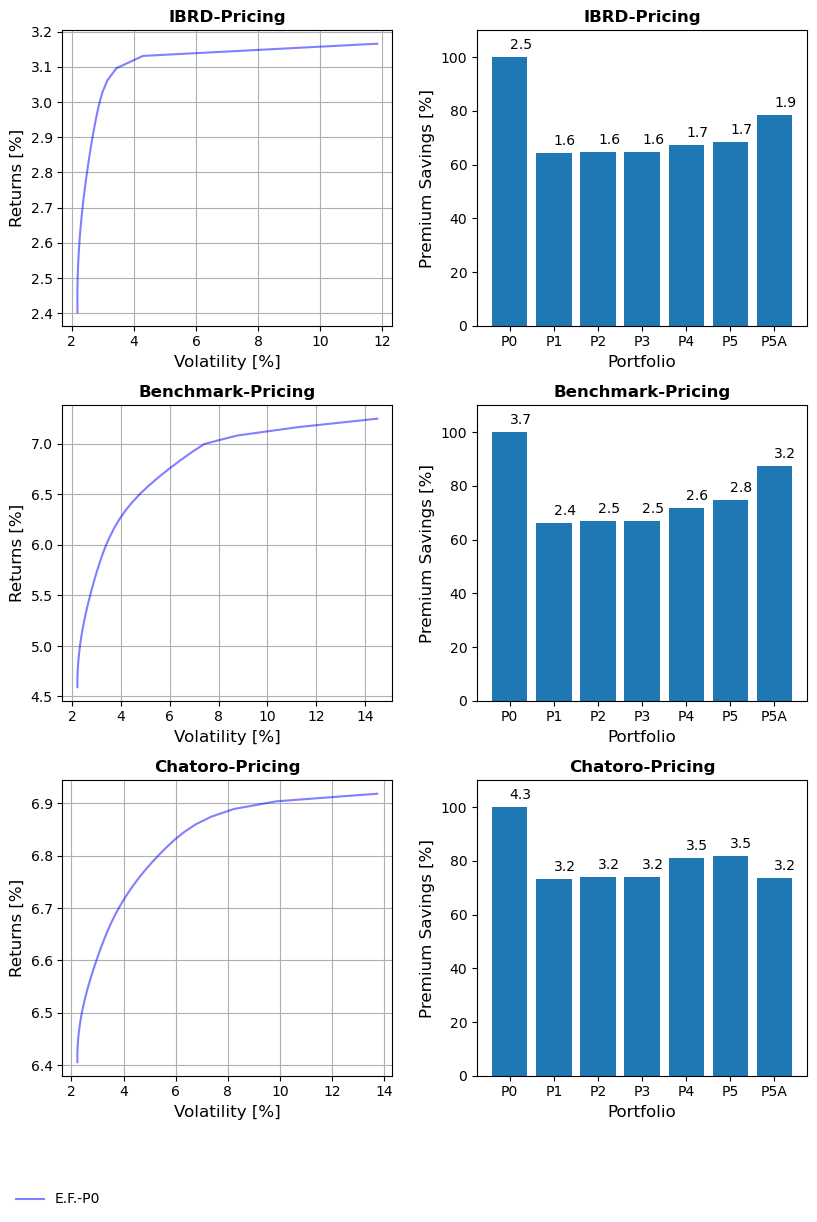

In [827]:
# use returns, premium payments and payouts to derive efficient frontiers, premium savings and insurance multiples for each scenario and pricing approach
premiums_abs_keys = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P6A', 'P6AB']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['ibrd','required', 'regression'] 
premium_methods_title = ['IBRD-Pricing', 'Benchmark-Pricing', 'Chatoro-Pricing'] 
num_plots = len(premium_methods)
fig, axes = plt.subplots(num_plots, 2, figsize=(8.27, 4 * num_plots))  

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s1 = {}
    premiums_pool_s2 = {}
    premiums_pool_s3 = {}
    premiums_pool_s4 = {}
    premiums_pool_s5 = {}
    premiums_pool_s5_a = {}
    premiums_pool_s5_a_b = {}
    premiums_pool_s5_a_r = {}
    for pool, prem_modes in premiums_s1.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s1: 
                    premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
                else:  
                    premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
    for pool, prem_modes in premiums_s3.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s3:  
                    premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
    for pool, prem_modes in premiums_s4.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s4:  
                    premiums_pool_s4[key] += np.sum(values * nominal_s4[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s4[key] = np.sum(values * nominal_s4[pool])
    for pool, prem_modes in premiums_s5.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5: 
                    premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
    for pool, prem_modes in premiums_s5_a.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a:  
                    premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])
    for pool, prem_modes in premiums_s5_a_b.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_b:  
                    premiums_pool_s5_a_b[key] += np.sum(values * nominal_s5_a_b[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_b[key] = np.sum(values * nominal_s5_a_b[pool])
    for pool, prem_modes in premiums_s5_a_r.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_r: 
                    premiums_pool_s5_a_r[key] += np.sum(values * nominal_s5_a_r[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_r[key] = np.sum(values * nominal_s5_a_r[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_ibrd
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_ibrd
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_ibrd
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_ibrd
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_ibrd
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_ibrd
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_ibrd
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_ibrd
        s1_ann_ret = s1_ann_ret_ibrd
        s2_ann_ret = s2_ann_ret_ibrd
        s3_ann_ret = s3_ann_ret_ibrd
        s4_ann_ret = s4_ann_ret_ibrd
        s5_ann_ret = s5_ann_ret_ibrd
        s5_a_ann_ret = s5_a_ann_ret_ibrd
        s5_a_b_ann_ret = s5_a_b_ann_ret_ibrd
        s5_a_r_ann_ret = s5_a_r_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])
        threshold_ef = 0.024

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_regr
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_regr
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_regr
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_regr
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_regr
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_regr
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_regr
        s1_ann_ret = s1_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        s3_ann_ret = s3_ann_ret_regr
        s4_ann_ret = s4_ann_ret_regr
        s5_ann_ret = s5_ann_ret_regr
        s5_a_ann_ret = s5_a_ann_ret_regr
        s5_a_b_ann_ret = s5_a_b_ann_ret_regr
        s5_a_r_ann_ret = s5_a_r_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])
        threshold_ef = 0.064

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_requ
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_requ
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_requ
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_requ
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_requ
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_requ
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_requ
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_requ
        s1_ann_ret = s1_ann_ret_requ
        s2_ann_ret = s2_ann_ret_requ
        s3_ann_ret = s3_ann_ret_requ
        s4_ann_ret = s4_ann_ret_requ
        s5_ann_ret = s5_ann_ret_requ
        s5_a_ann_ret = s5_a_ann_ret_requ
        s5_a_b_ann_ret = s5_a_b_ann_ret_requ
        s5_a_r_ann_ret = s5_a_r_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
        threshold_ef = 0.0455
    else:
        print('Wrong input premium mode')
        continue

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s1 = pd.DataFrame({f"{country} Returns": returns for country, returns in s1_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s3 = pd.DataFrame({f"{country} Returns": returns for country, returns in s3_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s4 = pd.DataFrame({f"{country} Returns": returns for country, returns in s4_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s5 = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_tranches_ann_ret_df.items()}).dropna(axis=1)
    if prem_mode == 'ibrd':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_tranches_ann_ret_df.items()}).dropna(axis=1)
    elif prem_mode == 'required':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_b_tranches_ann_ret_df.items()}).dropna(axis=1)
    elif prem_mode == 'regression':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_r_tranches_ann_ret_df.items()}).dropna(axis=1)
    
    

    r = np.mean(df_returns,axis=0)
    r_s1= np.mean(df_returns_s1,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)
    r_s3= np.mean(df_returns_s3,axis=0)
    r_s4= np.mean(df_returns_s4,axis=0)
    r_s5= np.mean(df_returns_s5,axis=0)
    r_s5_a= np.mean(df_returns_s5_a,axis=0)

    covar = df_returns.cov()
    covar_s1 = df_returns_s1.cov()
    covar_s2 = df_returns_s2.cov()
    covar_s3 = df_returns_s3.cov()
    covar_s4 = df_returns_s4.cov()
    covar_s5 = df_returns_s5.cov()
    covar_s5_a = df_returns_s5_a.cov()

    target_returns = np.linspace(np.min(r), np.max(r), 50)  
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    risks_s1 = []
    target_returns_s1 = np.linspace(np.min(r_s1), np.max(r_s1), 50)
    for target_return in target_returns_s1:
        weights, risk = minimize_risk(target_return, r_s1, covar_s1)
        risks_s1.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    risks_s3 = []
    target_returns_s3 = np.linspace(np.min(r_s3), np.max(r_s3), 50)
    for target_return in target_returns_s3:
        weights, risk = minimize_risk(target_return, r_s3, covar_s3)
        risks_s3.append(risk)

    risks_s4 = []
    target_returns_s4 = np.linspace(np.min(r_s4), np.max(r_s4), 50)
    for target_return in target_returns_s4:
        weights, risk = minimize_risk(target_return, r_s4, covar_s4)
        risks_s4.append(risk)

    risks_s5 = []
    target_returns_s5 = np.linspace(np.min(r_s5), np.max(r_s5), 50)
    for target_return in target_returns_s5:
        weights, risk = minimize_risk(target_return, r_s5, covar_s5)
        risks_s5.append(risk)

    risks_s5_a = []
    target_returns_s5_a = np.linspace(np.min(r_s5_a), np.max(r_s5_a), 50)
    for target_return in target_returns_s5_a:
        weights, risk = minimize_risk(target_return, r_s5_a, covar_s5_a)
        risks_s5_a.append(risk)

    filtered_target_returns = [value for value in target_returns if value > threshold_ef]
    filtered_risks = [risks[i] for i in range(len(target_returns)) if target_returns[i] > threshold_ef]
    axes[j, 0].plot(np.array(filtered_risks)*100, np.array(filtered_target_returns)*100, label="E.F.-P0", color='blue', alpha=0.5)
    #axes[j, 0].plot(np.array(risks_s1)*100, np.array(target_returns_s1)*100, label="E.F.-P1", color='black', alpha=0.5)
    #axes[j, 0].plot(np.array(risks_s2)*100, np.array(target_returns_s2)*100, label="E.F.-P2", color='brown', alpha=0.5)
    #axes[j, 0].plot(np.array(risks_s3)*100, np.array(target_returns_s3)*100, label="E.F.-P3", color='orange', alpha=0.5)
    #axes[j, 0].plot(np.array(risks_s4)*100, np.array(target_returns_s4)*100, label="E.F.-P4", color='green', alpha=0.5)
    #axes[j, 0].plot(np.array(risks_s5)*100, np.array(target_returns_s5)*100, label="E.F.-P5", color='red', alpha=0.5)
    #axes[j, 0].plot(np.array(risks_s5_a)*100, np.array(target_returns_s5_a)*100, label="E.F.-P5A", color='red', linestyle='--', alpha=0.5)

    #for i, cty in enumerate(countries):
    #    if i == 0:
    #        axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', label='P0-Bonds', s=100, alpha=0.5)
    #    else: 
    #        axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', s=100)
    #for pool in s1_ann_ret:
    #    if pool == '1':
    #        axes[j, 0].scatter(np.std(s1_ann_ret[pool])*100, np.mean(s1_ann_ret[pool])*100, color='black', label=f'P1-Bonds', s=100, alpha=0.5)
    #    else:
    #        axes[j, 0].scatter(np.std(s1_ann_ret[pool])*100, np.mean(s1_ann_ret[pool])*100, color='black', s=100, alpha=0.5)
    #for pool in s2_ann_ret:
    #    if pool == '1':
    #        axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='brown', label=f'P2-Bonds', s=100, alpha=0.5)
    #    else:
    #        axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='brown', s=100, alpha=0.5)
    #for pool in s3_ann_ret:
    #    if pool == '1':
    #        axes[j, 0].scatter(np.std(s3_ann_ret[pool])*100, np.mean(s3_ann_ret[pool])*100, color='orange', label=f'P3-Bonds', s=100, alpha=0.5)
    #    else:
    #        axes[j, 0].scatter(np.std(s3_ann_ret[pool])*100, np.mean(s3_ann_ret[pool])*100, color='orange', s=100, alpha=0.5)
    #for pool in s4_ann_ret:
    #    if pool == '1':
    #        axes[j, 0].scatter(np.std(s4_ann_ret[pool])*100, np.mean(s4_ann_ret[pool])*100, color='green', label=f'P4-Bonds', s=100, alpha=0.5)
    #    else:
    #        axes[j, 0].scatter(np.std(s4_ann_ret[pool])*100, np.mean(s4_ann_ret[pool])*100, color='green', s=100, alpha=0.5)
    #for pool in s5_ann_ret:
    #    if pool == '1':
    #        axes[j, 0].scatter(np.std(s5_ann_ret[pool])*100, np.mean(s5_ann_ret[pool])*100, color='red', label=f'P5-Bonds', s=100, alpha=0.5)
    #    else:
    #        axes[j, 0].scatter(np.std(s5_ann_ret[pool])*100, np.mean(s5_ann_ret[pool])*100, color='red', s=100, alpha=0.5)
    #colors = ['red', 'orange', 'green', 'blue', 'black', 'brown']
    #iterator_color = 0
    #for pool in s5_a_ann_ret:
    #    if pool == '1':
    #        if prem_mode == 'ibrd':
    #            axes[j, 0].scatter(np.std(s5_a_ann_ret[pool])*100, np.mean(s5_a_ann_ret[pool])*100, color='red', label=f'P5A-Bonds', marker='X', s=100, alpha=0.5)
    #        elif prem_mode == 'required':
    #            axes[j, 0].scatter(np.std(s5_a_b_ann_ret[pool])*100, np.mean(s5_a_b_ann_ret[pool])*100, color='red', label=f'P5A-Bonds', marker='X', s=100, alpha=0.5)
    #        else:
    #            axes[j, 0].scatter(np.std(s5_a_r_ann_ret[pool])*100, np.mean(s5_a_r_ann_ret[pool])*100, color=colors[iterator_color], label=f'P5A-Bonds', marker='X', s=100, alpha=0.5)
    #    else:
    #        if prem_mode == 'ibrd': 
    #            axes[j, 0].scatter(np.std(s5_a_ann_ret[pool])*100, np.mean(s5_a_ann_ret[pool])*100, color='red', marker='X', s=100, alpha=0.5)
    #        elif prem_mode == 'required':
    #            axes[j, 0].scatter(np.std(s5_a_b_ann_ret[pool])*100, np.mean(s5_a_b_ann_ret[pool])*100, color='red', marker='X', s=100, alpha=0.5)
    #        else:
    #            axes[j, 0].scatter(np.std(s5_a_r_ann_ret[pool])*100, np.mean(s5_a_r_ann_ret[pool])*100, color=colors[iterator_color], marker='X', s=100, alpha=0.5)
    #    iterator_color += 1
    axes[j, 0].set_xlabel("Volatility [%]", fontsize=12)
    axes[j, 0].set_ylabel("Returns [%]", fontsize=12)
    axes[j, 0].grid(True)
    axes[j, 0].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')

    x_labels = ["P0", "P1", "P2", "P3", "P4", "P5", "P5A"]

    s = sng_cty_premium
    if prem_mode == 'ibrd':
        prem_diff = [np.sum(s)/np.sum(s), 
                     np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     np.sum(premiums_pool_s2['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s4['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5_a['Total_alt'])/np.sum(s)]
    elif prem_mode == 'required':
        prem_diff = [np.sum(s)/np.sum(s), 
                     np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     np.sum(premiums_pool_s2['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s4['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5_a_b['Total_alt'])/np.sum(s)]
    else:
        prem_diff = [np.sum(s)/np.sum(s), 
                     np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     np.sum(premiums_pool_s2['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s4['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5_a_r['Total_alt'])/np.sum(s)]

    tot_pay_s1 = 0

    for pool in es_metrics_s1:
        tot_pay_s1 += es_metrics_s1[pool]['Payout']


    if prem_mode == 'ibrd':
        im = [np.sum(s)/np.sum(sng_cty_pay), 
              np.sum(premiums_pool_s1['Total_alt'])/tot_pay_s1, 
              np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s3['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s4['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5_a['Total_alt'])/tot_pay_s1]
    elif prem_mode == 'required':
        im = [np.sum(s)/np.sum(sng_cty_pay), 
              np.sum(premiums_pool_s1['Total_alt'])/tot_pay_s1, 
              np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s3['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s4['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5_a_b['Total_alt'])/tot_pay_s1]
    else:
        im = [np.sum(s)/np.sum(sng_cty_pay), 
              np.sum(premiums_pool_s1['Total_alt'])/tot_pay_s1, 
              np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s3['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s4['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5_a_r['Total_alt'])/tot_pay_s1]

    for q in range(len(im)):
        axes[j, 1].text(x_labels[q], prem_diff[q]*100+3, round(im[q],1))
    axes[j, 1].bar(x_labels, np.array(prem_diff)*100, label='Premium Savings')
    axes[j, 1].set_xlabel("Portfolio", fontsize=12)
    axes[j, 1].set_ylabel("Premium Savings [%]", fontsize=12)
    axes[j, 1].set_ylim(0, 110)
    axes[j, 1].tick_params(axis='y')
    axes[j, 1].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')
    
    premiums_abs['P1'][prem_mode] = np.sum(sng_cty_premium)/len(sng_ann_ret['212'])
    premiums_abs['P2'][prem_mode] = premiums_pool_s1['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P3'][prem_mode] = premiums_pool_s2['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P4'][prem_mode] = premiums_pool_s3['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P5'][prem_mode] = premiums_pool_s4['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P6'][prem_mode] = premiums_pool_s5['Total_alt']/len(sng_ann_ret['212'])
    if prem_mode == 'ibrd':
        premiums_abs['P6A'][prem_mode] = premiums_pool_s5_a['Total_alt']/len(sng_ann_ret['212'])
    elif prem_mode == 'required':
        premiums_abs['P6A'][prem_mode] = premiums_pool_s5_a_b['Total_alt']/len(sng_ann_ret['212'])
    elif prem_mode == 'regression':
        premiums_abs['P6A'][prem_mode] = premiums_pool_s5_a_r['Total_alt']/len(sng_ann_ret['212'])

    print(f"Sng Premiums {prem_mode}: {premiums_abs['P1'][prem_mode]}; {prem_diff[0]}")
    print(f"P2 Premiums {prem_mode}: {premiums_abs['P2'][prem_mode]}; {prem_diff[1]}")
    print(f"P3 Premiums {prem_mode}: {premiums_abs['P3'][prem_mode]}; {prem_diff[2]}")
    print(f"P4 Premiums {prem_mode}: {premiums_abs['P4'][prem_mode]}; {prem_diff[3]}")
    print(f"P5 Premiums {prem_mode}: {premiums_abs['P5'][prem_mode]}; {prem_diff[4]}")
    print(f"P6 Premiums {prem_mode}: {premiums_abs['P6'][prem_mode]}; {prem_diff[5]}")
    print(f"P6A Premiums {prem_mode}: {premiums_abs['P6A'][prem_mode]}; {prem_diff[6]}")

nominal_sng = 0
for key in nominal_sng_dic:
    nominal_sng += nominal_sng_dic[key]
print(f"Sng Nominal: {nominal_sng}")
print(f"P2 Nominal: {nominal_s1['1']}; {nominal_s1['1']/nominal_sng}")
nominal_pool_s2 = 0
for key in nominal_s2:
    nominal_pool_s2 += nominal_s2[key]
print(f"P3 Nominal: {nominal_pool_s2}; {nominal_pool_s2/nominal_sng}")
nominal_pool_s3 = 0
for key in nominal_s3:
    nominal_pool_s3 += nominal_s3[key]
print(f"P4 Nominal: {nominal_pool_s3}; {nominal_pool_s3/nominal_sng}")
nominal_pool_s4 = 0
for key in nominal_s4:
    nominal_pool_s4 += nominal_s4[key]
print(f"P5 Nominal: {nominal_pool_s4}; {nominal_pool_s4/nominal_sng}")
nominal_pool_s5 = 0
for key in nominal_s5:
    nominal_pool_s5 += nominal_s5[key]
print(f"P6 Nominal: {nominal_pool_s5}; {nominal_pool_s5/nominal_sng}")



handles0, labels0 = axes[j, 0].get_legend_handles_labels()
fig.legend(
    handles0,
    labels0,
    loc='lower left',
    bbox_to_anchor=(0.01, -0.02),
    ncol=4,
    frameon=False,
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


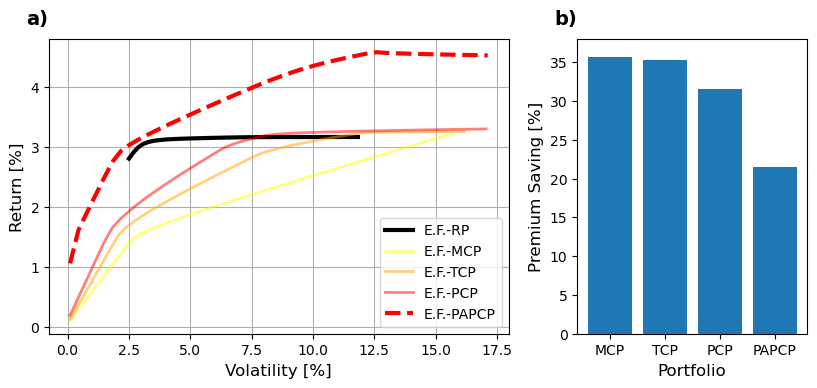

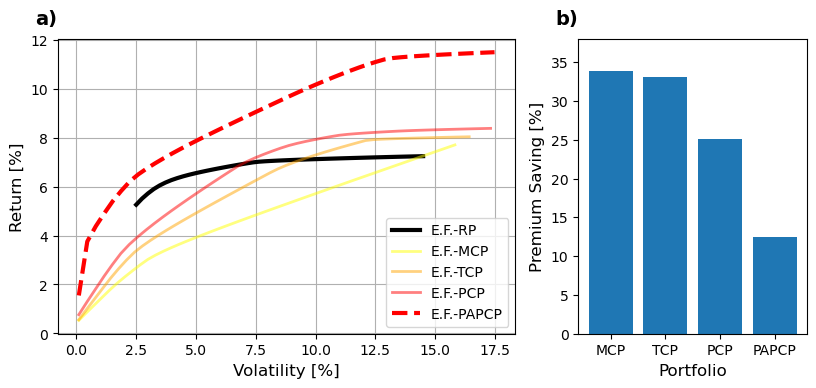

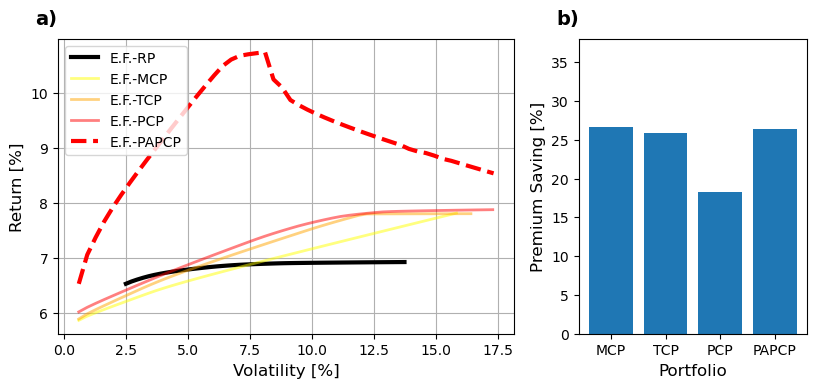

In [915]:
# use returns, premium payments and payouts to derive efficient frontiers, premium savings and insurance multiples for each scenario and pricing approach
premiums_abs_keys = ['P1', 'P3', 'P5', 'P6', 'P6A', 'P6AB']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['ibrd','required', 'regression' ] 
premium_methods_title = ['IBRD-Pricing', 'Benchmark-Pricing', 'Chatoro-Pricing'] 


for j, prem_mode in enumerate(premium_methods): 
    num_plots = len(premium_methods)
    fig, axes = plt.subplots(1, 2, figsize=(8.27, 4), gridspec_kw={'width_ratios': [2, 1]}) 
    premiums_pool_s1 = {}
    premiums_pool_s3 = {}
    premiums_pool_s5 = {}
    premiums_pool_s5_a = {}
    premiums_pool_s5_a_b = {}
    premiums_pool_s5_a_r = {}
    for pool, prem_modes in premiums_s1.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s1: 
                    premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
                else:  
                    premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
    for pool, prem_modes in premiums_s3.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s3:  
                    premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
    for pool, prem_modes in premiums_s5.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5: 
                    premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
    for pool, prem_modes in premiums_s5_a.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a:  
                    premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])
    for pool, prem_modes in premiums_s5_a_b.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_b:  
                    premiums_pool_s5_a_b[key] += np.sum(values * nominal_s5_a_b[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_b[key] = np.sum(values * nominal_s5_a_b[pool])
    for pool, prem_modes in premiums_s5_a_r.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_r: 
                    premiums_pool_s5_a_r[key] += np.sum(values * nominal_s5_a_r[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_r[key] = np.sum(values * nominal_s5_a_r[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_ibrd
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_ibrd
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_ibrd
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_ibrd
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_ibrd
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_ibrd
        s1_ann_ret = s1_ann_ret_ibrd
        s3_ann_ret = s3_ann_ret_ibrd
        s5_ann_ret = s5_ann_ret_ibrd
        s5_a_ann_ret = s5_a_ann_ret_ibrd
        s5_a_b_ann_ret = s5_a_b_ann_ret_ibrd
        s5_a_r_ann_ret = s5_a_r_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])
        min_std_add = 0.0

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_regr
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_regr
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_regr
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_regr
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_regr
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_regr
        s1_ann_ret = s1_ann_ret_regr
        s3_ann_ret = s3_ann_ret_regr
        s5_ann_ret = s5_ann_ret_regr
        s5_a_ann_ret = s5_a_ann_ret_regr
        s5_a_b_ann_ret = s5_a_b_ann_ret_regr
        s5_a_r_ann_ret = s5_a_r_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])
        min_std_add = 0.005

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_requ
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_requ
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_requ
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_requ
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_requ
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_requ
        s1_ann_ret = s1_ann_ret_requ
        s3_ann_ret = s3_ann_ret_requ
        s5_ann_ret = s5_ann_ret_requ
        s5_a_ann_ret = s5_a_ann_ret_requ
        s5_a_b_ann_ret = s5_a_b_ann_ret_requ
        s5_a_r_ann_ret = s5_a_r_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
        min_std_add = 0.00
    else:
        print('Wrong input premium mode')
        continue

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s1 = pd.DataFrame({f"{country} Returns": returns for country, returns in s1_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s3 = pd.DataFrame({f"{country} Returns": returns for country, returns in s3_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s5 = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_tranches_ann_ret_df.items()}).dropna(axis=1)
    if prem_mode == 'ibrd':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_tranches_ann_ret_df.items()}).dropna(axis=1)
    elif prem_mode == 'required':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_b_tranches_ann_ret_df.items()}).dropna(axis=1)
    elif prem_mode == 'regression':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_r_tranches_ann_ret_df.items()}).dropna(axis=1)
    
    

    r = np.mean(df_returns,axis=0)
    r_s1= np.mean(df_returns_s1,axis=0)
    r_s3= np.mean(df_returns_s3,axis=0)
    r_s5= np.mean(df_returns_s5,axis=0)
    r_s5_a= np.mean(df_returns_s5_a,axis=0)

    covar = df_returns.cov()
    covar_s1 = df_returns_s1.cov()
    covar_s3 = df_returns_s3.cov()
    covar_s5 = df_returns_s5.cov()
    covar_s5_a = df_returns_s5_a.cov()

    r_idx_max = r.argmax()
    num_assets = len(r)
    initial_guess = np.zeros(int(num_assets))
    target_volatilities = np.linspace(0.025, df_returns.iloc[:, r_idx_max].std(), 50)
    returns = []
    for x, target_volatility in enumerate(target_volatilities):
        initial_guess[r_idx_max] = x * 0.02
        for idx in range(len(initial_guess)):
            if idx != r_idx_max:
                initial_guess[idx] = (1 - initial_guess[r_idx_max]) / (len(initial_guess) - 1)
        weights, ret = maximize_return_given_risk(target_volatility, r, covar, initial_guess)
        returns.append(ret)

    returns_s1 = []
    initial_guess_s1 = np.ones(len(r_s1)) / len(r_s1)
    target_volatilities_s1 = np.linspace(0.001+min_std_add, df_returns_s1.std().max(), 50)
    for target_volatility in target_volatilities_s1:
        weights, ret = maximize_return_given_risk(target_volatility, r_s1, covar_s1, initial_guess_s1)
        returns_s1.append(ret)

    returns_s3 = []
    initial_guess_s3 = np.ones(len(r_s3)) / len(r_s3)
    target_volatilities_s3 = np.linspace(0.001+min_std_add, df_returns_s3.std().max(), 50)
    for target_volatility in target_volatilities_s3:
        weights, ret = maximize_return_given_risk(target_volatility, r_s3, covar_s3, initial_guess_s3)
        returns_s3.append(ret)

    returns_s5 = []
    initial_guess_s5 = np.ones(len(r_s5)) / len(r_s5)
    target_volatilities_s5 = np.linspace(0.001+min_std_add, df_returns_s5.std().max(), 50)
    for target_volatility in target_volatilities_s5:
        weights, ret = maximize_return_given_risk(target_volatility, r_s5, covar_s5, initial_guess_s5)
        returns_s5.append(ret)

    returns_s5_a = []
    initial_guess_s5_a = np.ones(len(r_s5_a)) / len(r_s5_a)
    target_volatilities_s5_a = np.linspace(0.001+min_std_add, df_returns_s5_a.std().max(), 50)
    for target_volatility in target_volatilities_s5_a:
        weights, ret = maximize_return_given_risk(target_volatility, r_s5_a, covar_s5_a, initial_guess_s5_a)
        returns_s5_a.append(ret)

    axes[0].plot(np.array(target_volatilities)*100, np.array(returns)*100, label="E.F.-RP", color='black', alpha=1, linewidth=3)
    axes[0].plot(np.array(target_volatilities_s1)*100, np.array(returns_s1)*100, label="E.F.-MCP", color='yellow', alpha=0.5, linewidth=2)
    axes[0].plot(np.array(target_volatilities_s3)*100, np.array(returns_s3)*100, label="E.F.-TCP", color='orange', alpha=0.5, linewidth=2)
    axes[0].plot(np.array(target_volatilities_s5)*100, np.array(returns_s5)*100, label="E.F.-PCP", color='red', alpha=0.5, linewidth=2)
    axes[0].plot(np.array(target_volatilities_s5_a)*100, np.array(returns_s5_a)*100, label="E.F.-PAPCP", color='red', linestyle='--', alpha=1, linewidth=3)

    axes[0].set_xlabel("Volatility [%]", fontsize=12)
    axes[0].set_ylabel("Return [%]", fontsize=12)
    axes[0].grid(True)
    #axes[0].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')

    x_labels = ["MCP", "TCP", "PCP", "PAPCP"]

    s = sng_cty_premium
    if prem_mode == 'ibrd':
        prem_diff = [1 - np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     1 - np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     1 - np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     1 - np.sum(premiums_pool_s5_a['Total_alt'])/np.sum(s)]
    elif prem_mode == 'required':
        prem_diff = [1 - np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     1 - np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     1 - np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     1 - np.sum(premiums_pool_s5_a_b['Total_alt'])/np.sum(s)]
    else:
        prem_diff = [1 - np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     1 - np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     1 - np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     1 - np.sum(premiums_pool_s5_a_r['Total_alt'])/np.sum(s)]

    axes[1].bar(x_labels, np.array(prem_diff)*100, label='Premium Savings')
    axes[1].set_xlabel("Portfolio", fontsize=12)
    axes[1].set_ylabel("Premium Saving [%]", fontsize=12)
    axes[1].set_ylim(0.0, 38)
    axes[1].tick_params(axis='y')
    #axes[1].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')

    axes[0].legend()
    # Add subplot labels "a)" and "b)" in the top left corner, slightly outside the plot
    axes[0].text(-0.05, 1.1, "a)", transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    axes[1].text(-0.1, 1.1, "b)", transform=axes[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    plt.tight_layout(rect=[0, 0.0, 1, 1])
    plt.show()
    fig.savefig(Path(save_path, f"Plots/port_ef_ps_{prem_mode}.pdf"), bbox_inches="tight")



In [882]:
df_returns.iloc[:, 3].std()

0.11833533528240985

In [891]:
print(x)
print(initial_guess)
print(target_volatility)

66
[0.05       0.03958333 0.03958333 0.03958333 0.03958333 0.03958333
 0.03958333 0.03958333 0.03958333 0.03958333 0.03958333 0.03958333
 0.03958333 0.03958333 0.03958333 0.03958333 0.03958333 0.03958333
 0.03958333 0.03958333 0.03958333 0.03958333 0.03958333 0.03958333
 0.03958333]
0.13664964063034177


In [926]:
# use returns, premium payments and payouts to derive efficient frontiers, premium savings and insurance multiples for each scenario and pricing approach
premiums_abs_keys = ['P1', 'P3', 'P5', 'P6', 'P6A', 'P6AB']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['ibrd','required', 'regression'] 
premium_methods_title = ['IBRD-Pricing', 'Benchmark-Pricing', 'Chatoro-Pricing'] 

prem_diff = {'ibrd': {},'required': {}, 'regression': {}}

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s1 = {}
    premiums_pool_s3 = {}
    premiums_pool_s5 = {}
    premiums_pool_s5_a = {}
    premiums_pool_s5_a_b = {}
    premiums_pool_s5_a_r = {}
    for pool, prem_modes in premiums_s1.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s1: 
                    premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
                else:  
                    premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
    for pool, prem_modes in premiums_s3.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s3:  
                    premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
    for pool, prem_modes in premiums_s5.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5: 
                    premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
    for pool, prem_modes in premiums_s5_a.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a:  
                    premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])
    for pool, prem_modes in premiums_s5_a_b.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_b:  
                    premiums_pool_s5_a_b[key] += np.sum(values * nominal_s5_a_b[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_b[key] = np.sum(values * nominal_s5_a_b[pool])
    for pool, prem_modes in premiums_s5_a_r.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_r: 
                    premiums_pool_s5_a_r[key] += np.sum(values * nominal_s5_a_r[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_r[key] = np.sum(values * nominal_s5_a_r[pool])

    sng_cty_premium = []  
    s = {'P0': None, 'P1': [], 'P3': [], 'P5': [], 'P5A': []}
    s['P0'] = sng_cty_premium

    if prem_mode == 'ibrd':
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0]/len(sng_ann_ret['212']))

        s['P0'] = sng_cty_premium
        for cty in countries:
            s['P1'].append(np.sum(premiums_pool_s1[cty])/len(sng_ann_ret['212']))
            s['P3'].append(np.sum(premiums_pool_s3[cty])/len(sng_ann_ret['212']))
            s['P5'].append(np.sum(premiums_pool_s5[cty])/len(sng_ann_ret['212']))
            s['P5A'].append(np.sum(premiums_pool_s5_a[cty])/len(sng_ann_ret['212']))

    elif prem_mode == 'regression':
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1]/len(sng_ann_ret['212']))

        s['P0'] = sng_cty_premium
        for cty in countries:
            s['P1'].append(np.sum(premiums_pool_s1[cty])/len(sng_ann_ret['212']))
            s['P3'].append(np.sum(premiums_pool_s3[cty])/len(sng_ann_ret['212']))
            s['P5'].append(np.sum(premiums_pool_s5[cty])/len(sng_ann_ret['212']))
            s['P5A'].append(np.sum(premiums_pool_s5_a_r[cty])/len(sng_ann_ret['212']))

    elif prem_mode == 'required':
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2]/len(sng_ann_ret['212']))

        s['P0'] = sng_cty_premium
        for cty in countries:
            s['P1'].append(np.sum(premiums_pool_s1[cty])/len(sng_ann_ret['212']))
            s['P3'].append(np.sum(premiums_pool_s3[cty])/len(sng_ann_ret['212']))
            s['P5'].append(np.sum(premiums_pool_s5[cty])/len(sng_ann_ret['212']))
            s['P5A'].append(np.sum(premiums_pool_s5_a_b[cty])/len(sng_ann_ret['212']))

    else:
        print('Wrong input premium mode')
        continue

    for key in s:
        prem_diff[prem_mode][key] = (1-(np.array(s[key])/np.array(s['P0']))).tolist()
        prem_diff[prem_mode][key].append(1 - np.sum(s[key])/np.sum(s['P0']))

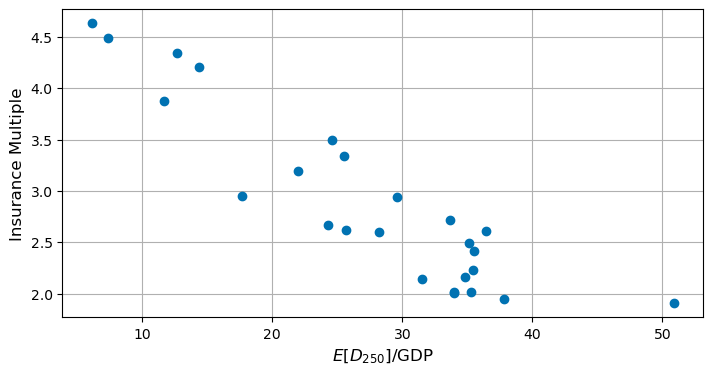

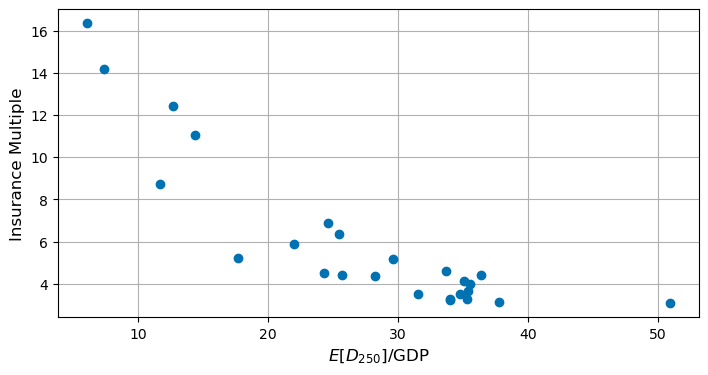

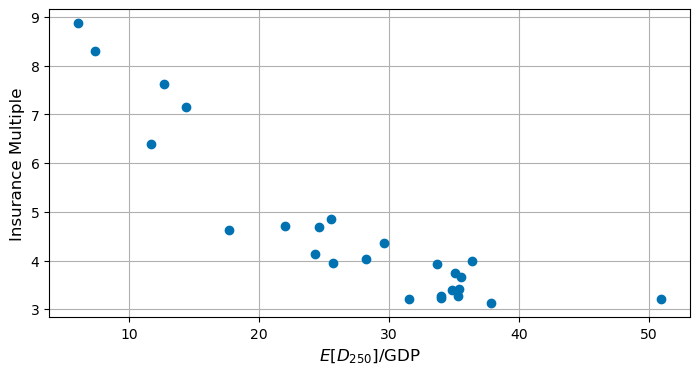

In [917]:
sng_cty_premium_ibrd=[]
sng_cty_premium_regr=[]
sng_cty_premium_bench=[]
sng_cty_im_ibrd=[]
sng_cty_im_regr=[]
sng_cty_im_bench=[]
for cty in bond_metrics_sng_dic:
            sng_cty_premium_ibrd.append(bond_metrics_sng_dic[cty]['Total Premiums'][0]/len(sng_ann_ret_df_ibrd.iloc[:,1]))
            sng_cty_premium_regr.append(bond_metrics_sng_dic[cty]['Total Premiums'][1]/len(sng_ann_ret_df_ibrd.iloc[:,1]))
            sng_cty_premium_bench.append(bond_metrics_sng_dic[cty]['Total Premiums'][2]/len(sng_ann_ret_df_ibrd.iloc[:,1]))
            sng_cty_im_ibrd.append(bond_metrics_sng_dic[cty]['Total Premiums'][0]/bond_metrics_sng_dic[cty]['Summed Payments'][0])
            sng_cty_im_regr.append(bond_metrics_sng_dic[cty]['Total Premiums'][1]/bond_metrics_sng_dic[cty]['Summed Payments'][1])
            sng_cty_im_bench.append(bond_metrics_sng_dic[cty]['Total Premiums'][2]/bond_metrics_sng_dic[cty]['Summed Payments'][2])

gdp_per_cty = [
    14.40e9, 0.65e9, 0.93e9, 19.85e9, 1.07e9, 2.03e9, 19.42e9, 6.39e9, 1.08e9, 2.52e9,
    1.32e9, 121.44e9, 14.34e9, 1.13e9, 5.49e9, 28.14e9, 107.35e9, 0.04e9, 3.28e9, 0.50e9,
    1.63e9, 1.35e9, 0.34e9, 0.28e9, 0.26e9
]

ed250 = [
    50.9, 37.8, 36.4, 35.5, 35.4, 35.3, 35.1, 34.8, 34.0, 34.0,
    33.7, 31.5, 29.6, 28.2, 25.7, 25.5, 24.6, 24.3, 22.0, 17.7,
    14.4, 12.7, 11.7, 7.4, 6.1
]

# Compute premium as a share of GDP
ibrd_gdp_ratio = [p / g for p, g in zip(sng_cty_premium_ibrd, gdp_per_cty)]
regr_gdp_ratio = [p / g for p, g in zip(sng_cty_premium_regr, gdp_per_cty)]
bench_gdp_ratio = [p / g for p, g in zip(sng_cty_premium_bench, gdp_per_cty)]

pricing_list = ['IBRD-Pricing', 'Chatoro-Pricing', 'Benchmark-Pricing']
for p_name in pricing_list:
    if p_name == 'IBRD-Pricing':
        fig = plt.figure(figsize=(8.27, 4))
        plt.plot(ed250, sng_cty_im_ibrd, 'o', label='IBRD-Pricing', color='#0072B2')
        plt.xlabel(r"$E[D_{250}]$/GDP", fontsize=12)
        plt.ylabel('Insurance Multiple', fontsize=12)
        #plt.title('IBRD-Pricing', fontsize=12, fontweight='bold')
        plt.grid(True)
        plt.savefig(f'{save_path}/Plots/cty_level_im_{p_name}.pdf', bbox_inches='tight')
        plt.show()
    elif p_name == 'Chatoro-Pricing':
        fig = plt.figure(figsize=(8.27, 4))
        plt.plot(ed250, sng_cty_im_regr, 'o', label='Chatoro-Pricing', color='#0072B2')
        plt.xlabel(r"$E[D_{250}]$/GDP", fontsize=12)
        plt.ylabel('Insurance Multiple', fontsize=12)
        #plt.title('Chatoro-Pricing', fontsize=12, fontweight='bold')
        plt.grid(True)
        plt.savefig(f'{save_path}/Plots/cty_level_im_{p_name}.pdf', bbox_inches='tight')
        plt.show()
    elif p_name == 'Benchmark-Pricing':
        fig = plt.figure(figsize=(8.27, 4))
        plt.plot(ed250, sng_cty_im_bench, 'o', label='Benchmark-Pricing', color='#0072B2')
        plt.xlabel(r"$E[D_{250}]$/GDP", fontsize=12)
        plt.ylabel('Insurance Multiple', fontsize=12)
        #plt.title('Benchmark-Pricing', fontsize=12, fontweight='bold')
        plt.grid(True)
        plt.savefig(f'{save_path}/Plots/cty_level_im_{p_name}.pdf', bbox_inches='tight')
        plt.show()

NameError: name 'inset_axes' is not defined

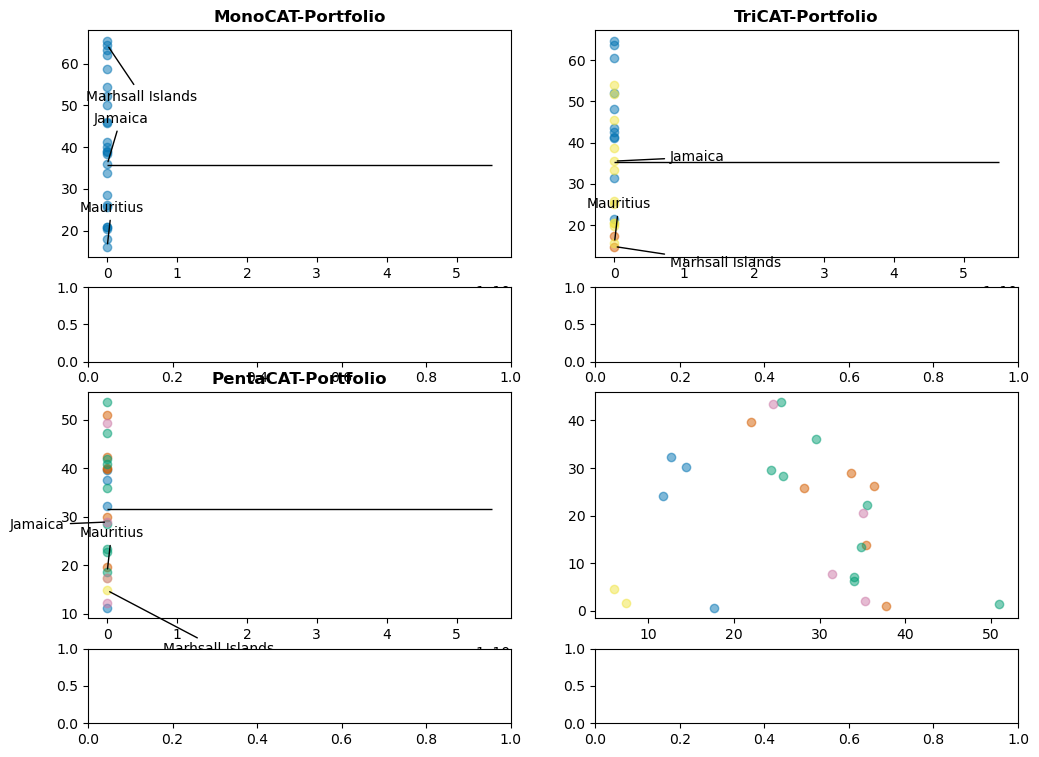

In [934]:
nominal_dic = {
    's1': nominal_s1,
    's3': nominal_s3,
    's5': nominal_s5,
}

scenarios_dic = {
    's1': scenario_1,
    's3': scenario_3,
    's5': scenario_5,
}

fct.plt_cty_level_ps_pool(bond_metrics_sng_dic, premium_dic_sng_dic, sng_ann_ret_df_ibrd, countries, prem_diff, scenarios_dic, nominal_dic, 'ed250_rel', save_path)
#fct.plt_cty_level_ps_pool(bond_metrics_sng_dic, premium_dic_sng_dic, sng_ann_ret_df_ibrd, countries, prem_diff, scenarios_dic, nominal_dic, 'el', save_path)

In [922]:
# Find the maximum and minimum value in the prem_diff dictionary
max_val = None
min_val = None
max_key = None
min_key = None

for mode, portfolios in prem_diff.items():
    for port, values in portfolios.items():
        if isinstance(values, list) and values:  # Ensure it's a non-empty list
            local_max = max(values)
            local_min = min(values)
            if (max_val is None) or (local_max > max_val):
                max_val = local_max
                max_key = (mode, port)
            if (min_val is None) or (local_min < min_val):
                min_val = local_min
                min_key = (mode, port)

print(f"Maximum value: {max_val} in {max_key}")
print(f"Minimum value: {min_val} in {min_key}")

Maximum value: 0.838745276399555 in ('regression', 'P2')
Minimum value: -0.18195292856830836 in ('regression', 'P5')


In [772]:
#create table for single country cat bonds -> summary
coverages = []
for key in bond_metrics_sng_dic:
    coverages.append(bond_metrics_sng_dic[key]['Coverage'][0])

exp_lsss = []
att_probs = []
for key in premium_dic_sng_dic:
    exp_lsss.append(premium_dic_sng_dic[key]['exp_loss'])
    att_probs.append(premium_dic_sng_dic[key]['att_prob'])

exp_lsss = np.array(exp_lsss) * 100
att_probs = np.array(att_probs) * 100
coverages = np.array(coverages) * 100
ibrd_gdp_ratio = np.array(ibrd_gdp_ratio) * 100
regr_gdp_ratio = np.array(regr_gdp_ratio) * 100
bench_gdp_ratio = np.array(bench_gdp_ratio) * 100
premium_gdp_ratio = ibrd_gdp_ratio + regr_gdp_ratio + bench_gdp_ratio

sng_cty_data_latex = pd.DataFrame({
    'Country': countries_str,
    'Coverage': np.round(coverages,1),
    'Expected Loss': np.round(exp_lsss, 1),
    'Attachment Probability': np.round(att_probs,1),
    'Premium-IBRD': np.round(ibrd_gdp_ratio, 1),
    'Premium-Chatoro': np.round(regr_gdp_ratio, 1),
    'Premium-Benchmark': np.round(bench_gdp_ratio, 1)
})
latex_table_sng_cty = sng_cty_data_latex.to_latex(index=False, float_format="%.1f", caption="Example Table", label="tab:example_table")
print(latex_table_sng_cty)

\begin{table}
\caption{Example Table}
\label{tab:example_table}
\begin{tabular}{lrrrrrr}
\toprule
Country & Coverage & Expected Loss & Attachment Probability & Premium-IBRD & Premium-Chatoro & Premium-Benchmark \\
\midrule
MUS & 92.0 & 3.3 & 7.7 & 2.5 & 4.0 & 4.2 \\
DMA & 90.9 & 3.2 & 7.2 & 1.8 & 3.0 & 3.0 \\
WSM & 86.9 & 1.9 & 4.0 & 1.7 & 2.9 & 2.6 \\
HIT & 91.0 & 2.2 & 4.6 & 1.4 & 2.3 & 2.1 \\
VCT & 90.0 & 2.6 & 5.5 & 1.6 & 2.7 & 2.5 \\
ATG & 91.6 & 3.0 & 6.2 & 1.5 & 2.4 & 2.4 \\
JAM & 87.5 & 2.1 & 4.4 & 1.3 & 2.2 & 2.0 \\
BRB & 90.2 & 2.7 & 5.6 & 1.5 & 2.5 & 2.4 \\
LCA & 89.9 & 3.1 & 6.4 & 2.9 & 4.7 & 4.7 \\
KNA & 90.2 & 3.0 & 6.1 & 0.7 & 1.2 & 1.2 \\
GRD & 88.2 & 1.8 & 3.9 & 1.3 & 2.2 & 1.9 \\
DOM & 79.4 & 2.7 & 6.3 & 1.2 & 2.0 & 1.8 \\
BHS & 88.6 & 1.6 & 2.8 & 0.9 & 1.7 & 1.4 \\
VUT & 87.8 & 1.9 & 3.6 & 1.1 & 1.9 & 1.8 \\
FJI & 78.6 & 1.9 & 3.9 & 1.0 & 1.8 & 1.6 \\
TTO & 78.8 & 1.2 & 2.1 & 0.8 & 1.4 & 1.1 \\
CUB & 77.9 & 1.1 & 2.2 & 0.9 & 1.8 & 1.3 \\
NIU & 84.7 & 1.9 & 3.4 & 0.3 

In [904]:
# set data of historical returns of norwegian pension fund
# Example data
risk_nor = np.array([0.02, 9.54, 4.80, 6.74, 17.83])  # Avoid zero to prevent issues
returns_nor = np.array([0.02, 4.29, 3.99, 4.42, 8.05])
labels = ["", "Ren. Infrastructure", "Fixed Income", "Real Estate", "Equity"] # forst entry is the risk free rate approximated as average 3-month US treasury bills

# Define the power law function to fit the risk return trendline
def power_law_func(x, a, b):
    return a * x**b

# Fit the trendline to the data
params, _ = curve_fit(power_law_func, risk_nor, returns_nor, maxfev=10000)
a, b = params

# Generate smooth values for the trendline
smooth_risk = np.linspace(0, max(risk_nor), 100)
smooth_trendline = power_law_func(smooth_risk, a, b)

In [776]:
rm_ibrd_pr = ((premiums_s5_a['5']['ibrd'][388].max() * nominal_s5_a['5'])/nominal_sng_dic[388] / 0.021)
rm_bench_pr = ((premiums_s5_a['5']['required'][388].max() * nominal_s5_a['5'])/nominal_sng_dic[388] / 0.021)
rm_regr_pr = ((premiums_s5_a['5']['regression'][388].max() * nominal_s5_a['5'])/nominal_sng_dic[388] / 0.021)

print(f"RM-IBRD: {rm_ibrd_pr}, RM-Bench: {rm_bench_pr}, RM-Regr: {rm_regr_pr}")

RM-IBRD: 2.06148031824637, RM-Bench: 3.280588531868615, RM-Regr: 4.240094509881641


In [909]:
df_returns_s5_a_i = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_tranches_ann_ret_ibrd.items()}).dropna(axis=1)
df_returns_s5_a_r = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_r_tranches_ann_ret_regr.items()}).dropna(axis=1)
df_returns_s5_a_b = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_b_tranches_ann_ret_requ.items()}).dropna(axis=1)
    
r_s5_a_i = np.mean(df_returns_s5_a_i,axis=0)
r_s5_a_r = np.mean(df_returns_s5_a_r,axis=0)
r_s5_a_b = np.mean(df_returns_s5_a_b,axis=0)

covar_s5_a_i = df_returns_s5_a_i.cov()
covar_s5_a_r = df_returns_s5_a_r.cov()
covar_s5_a_b = df_returns_s5_a_b.cov()

initial_guess = np.ones(len(r_s5_a_i)) / len(r_s5_a_i)
target_vols_s5 = np.linspace(0.005, 0.17, 50)
returns_s5_a_i = []
for target_vol in target_vols_s5:
    weights, ret = maximize_return_given_risk(target_vol, r_s5_a_i, covar_s5_a_i, initial_guess)
    returns_s5_a_i.append(ret)

# Repeat for the other portfolios
returns_s5_a_r = []
for target_vol in target_vols_s5:
    weights, ret = maximize_return_given_risk(target_vol, r_s5_a_r, covar_s5_a_r, initial_guess)
    returns_s5_a_r.append(ret)

returns_s5_a_b = []
for target_vol in target_vols_s5:
    weights, ret = maximize_return_given_risk(target_vol, r_s5_a_b, covar_s5_a_b, initial_guess)
    returns_s5_a_b.append(ret)


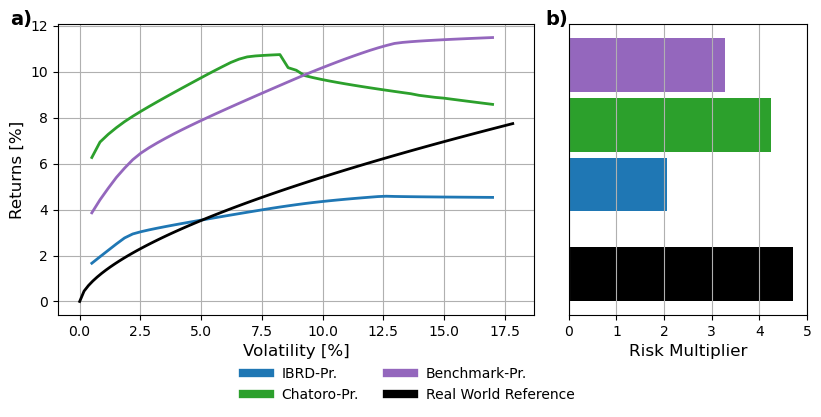

In [910]:
fig, axes = plt.subplots(1, 2, figsize=(8.27, 4), gridspec_kw={'width_ratios': [2, 1]}) 

# Left plot
axes[0].plot(np.array(target_vols_s5)*100, np.array(returns_s5_a_i)*100, color=colorblind_colors[0], linestyle='-', alpha=1.0, linewidth=2)
axes[0].plot(np.array(target_vols_s5)*100, np.array(returns_s5_a_r)*100, color=colorblind_colors[2], linestyle='-', alpha=1.0, linewidth=2)
axes[0].plot(np.array(target_vols_s5)*100, np.array(returns_s5_a_b)*100, color=colorblind_colors[4], linestyle='-', alpha=1.0, linewidth=2)
axes[0].plot(smooth_risk, smooth_trendline, color='black', linestyle='solid', alpha=1.0, linewidth=2)

axes[0].set_xlabel("Volatility [%]", fontsize=12)
axes[0].set_ylabel("Returns [%]", fontsize=12)
axes[0].grid(True)

# Right plot
hbar_colors = ['black', colorblind_colors[0], colorblind_colors[2], colorblind_colors[4]]
rm = [4.7, rm_ibrd_pr, rm_regr_pr, rm_bench_pr]
y_positions = [0, 1.5,2.5,3.5]

bars = axes[1].barh(y_positions, rm, color=hbar_colors, height=0.9)

axes[1].set_yticks([])  # Remove y-axis labels
axes[1].set_xlim(0, max(rm) + 0.3)
axes[1].set_xlabel("Risk Multiplier", fontsize=12)
axes[1].grid(True)

# Adjust spacing and add legend below the plots
custom_lines = [
    plt.Line2D([0], [0], color=colorblind_colors[0], lw=6),
    plt.Line2D([0], [0], color=colorblind_colors[2], lw=6),
    plt.Line2D([0], [0], color=colorblind_colors[4], lw=6),
    plt.Line2D([0], [0], color='black', lw=6)
]
fig.legend(custom_lines, ['IBRD-Pr.', 'Chatoro-Pr.', 'Benchmark-Pr.', 'Real World Reference'],
           loc='lower center', ncol=2, frameon=False, fontsize=10, bbox_to_anchor=(0.5, -0.05))

axes[0].text(-0.1, 1.05, "a)", transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
axes[1].text(-0.1, 1.05, "b)", transform=axes[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'{save_path}/Plots/ef_npf_car_jam_rm.pdf', bbox_inches='tight')
plt.show()

In [769]:
rm_regr_pr

4.240094509881641